In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2023-08-18 15:45:14.288649: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 15:45:14.291028: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 15:45:14.339173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 15:45:14.340049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 15:45:15.106445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
prom_file_path = "r14n17_tb.parquet"

In [3]:
prom_df = pd.read_parquet(prom_file_path)

In [4]:
prom_df = prom_df.drop(['node', 'timestamp'], axis=1)

In [12]:
from keras.models import load_model
model = load_model('r11n14_lstm_model.h5')

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

scaler_new = MinMaxScaler()
prom_df_scaled = pd.DataFrame(scaler_new.fit_transform(prom_df), columns=prom_df.columns)

if 'nvidia_gpu_temperature_celsius-max' not in prom_df_scaled.columns:
    prom_df_scaled['nvidia_gpu_temperature_celsius-max'] = 0

prom_df_scaled = prom_df_scaled[prom_df.columns.tolist()]

timesteps = 10  
sequences_new = np.array([prom_df_scaled[i: i + timesteps].values for i in range(len(prom_df_scaled) - timesteps)])


In [5]:
scaler = MinMaxScaler()
prom_df = pd.DataFrame(scaler.fit_transform(prom_df), columns=prom_df.columns)

labels = prom_df['isAnomaly']
prom_df = prom_df.drop('isAnomaly', axis=1)

timesteps = 10
n_features = prom_df.shape[1]

sequences = np.array([prom_df[i: i + timesteps].values for i in range(len(prom_df) - timesteps)])
labels = labels[timesteps:]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer=Adam(), loss='mse')


In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(sequences, sequences, epochs=25, batch_size=128, verbose=1, validation_split=0.2, callbacks=[es])

Epoch 1/25
231/231 [==============================] - 23s 86ms/step - loss: 0.0095 - val_loss: 4.6828e-04
Epoch 2/25
231/231 [==============================] - 19s 82ms/step - loss: 4.1008e-04 - val_loss: 2.4503e-04
Epoch 3/25
231/231 [==============================] - 19s 82ms/step - loss: 2.9952e-04 - val_loss: 2.5295e-04
Epoch 4/25
231/231 [==============================] - 19s 82ms/step - loss: 2.5262e-04 - val_loss: 1.8020e-04
Epoch 5/25
152/231 [==================>...........] - ETA: 5s - loss: 2.2030e-04

In [ ]:
model.save('r11n14_lstm_model.h5')

In [15]:
labels = prom_df['isAnomaly']
sequences = np.array([prom_df[i: i + timesteps].values for i in range(len(prom_df) - timesteps)])
labels = labels[timesteps:]

In [13]:
pred = model.predict(sequences)

mse = np.mean(np.power(sequences - pred, 2), axis=(1, 2))
threshold = np.percentile(mse, 67)  

pred_labels = [1 if e > threshold else 0 for e in mse]

2758/2758 [==============================] - 39s 14ms/step


In [16]:
print(classification_report(labels, pred_labels))
print(confusion_matrix(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     58108
           1       0.74      0.72      0.73     30126

    accuracy                           0.82     88234
   macro avg       0.80      0.80      0.80     88234
weighted avg       0.82      0.82      0.82     88234

[[50644  7464]
 [ 8473 21653]]


In [8]:
print(classification_report(labels, pred_labels))
print(confusion_matrix(labels, pred_labels))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     24550
         1.0       0.91      0.90      0.91     12286

    accuracy                           0.94     36836
   macro avg       0.93      0.93      0.93     36836
weighted avg       0.94      0.94      0.94     36836

[[23494  1056]
 [ 1186 11100]]


              precision    recall  f1-score   support

           0       0.86      0.87      0.86     58108
           1       0.74      0.72      0.73     30126

    accuracy                           0.82     88234
   macro avg       0.80      0.80      0.80     88234
weighted avg       0.82      0.82      0.82     88234

Confusion matrix:
 [[50644  7464]
 [ 8473 21653]]
ROC AUC Score: 0.7951487269221547


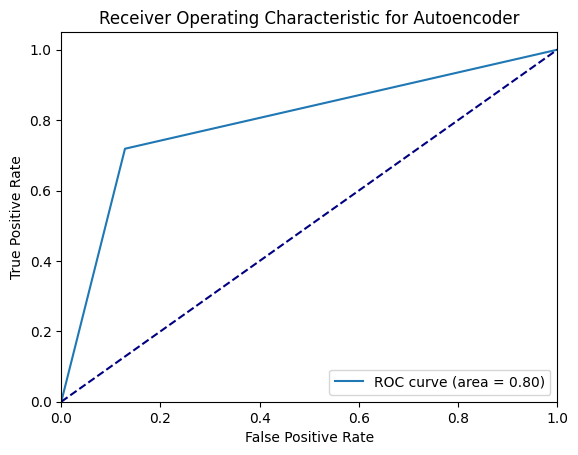

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
print(classification_report(labels, pred_labels))

conf_mat = confusion_matrix(labels, pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(labels, pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(labels, pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('lstmautoencoder_roc_curve_r14n17.pdf', format='pdf')

plt.show()

In [8]:
print(classification_report(labels, pred_labels))
print(confusion_matrix(labels, pred_labels))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     24550
         1.0       0.93      0.92      0.92     12286

    accuracy                           0.95     36836
   macro avg       0.94      0.94      0.94     36836
weighted avg       0.95      0.95      0.95     36836

[[23658   892]
 [ 1022 11264]]
